- 데이콘 베이직 Basic - 집값 예측 경진대회
- 평가 산식: NMAE
- 해당 커리큘럼은 안수빈님의 필사를 참고 하였습니다.
- https://www.kaggle.com/subinium/subinium-tutorial-house-prices-advanced

# Data load

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore') # warnings 무시
%matplotlib inline

# sns Theme 
sns.set_style('darkgrid')

In [140]:
# 데이터 읽기
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [141]:
# 데이터체크
print(train_df.shape, test_df.shape)
train_df.head(5)

(1350, 15) (1350, 14)


,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


target 값을 제외하면 총 13개의 피처를 가지고 있고, 그 외에는 데이터 분석과 상관 없는 id 특성도 있습니다.

In [142]:
# Save the 'Id' comlumn
train_ID = train_df['id']
test_ID = test_df['id']

train_df.drop('id', axis=1, inplace=True) # id 제거
test_df.drop('id', axis=1, inplace=True) # id 제거

# Data Processing

이상치 제거는 훈련에 있어 매우 좋은 방법입니다. 이상치를 일일히 찾아 제거하지 않는 이유는 다음과 같습니다.


- 이 외에도 훈련 데이터에 이상치가 많은 수 있지만, 테스트 데이터에도 이상치가 있을 수 있습니다.
- 그렇다면 오히려 모델에 안좋은 영향을 미칠 수 있습니다.

이런 이상치를 모두 제거하는 대신에 후에 모델에서 이런 데이터를 제거하는 방법을 배울 것입니다.

## Target Variable

186406.31259259259 78406.36921951386


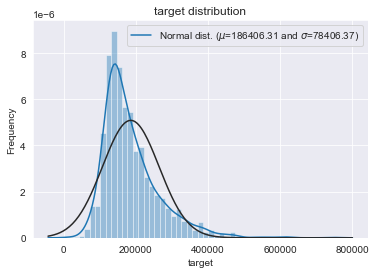

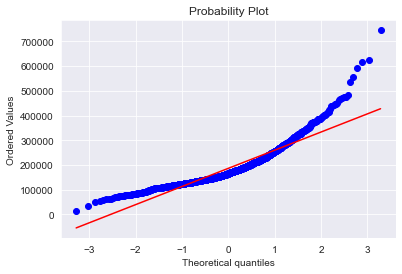

In [143]:
sns.distplot(train_df['target'], fit=norm)

(mu, sigma) = norm.fit(train_df['target'])
print(mu, sigma)

# 분포를 그래프에 그려봅시다.
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('target distribution')

# QQ-plot을 그려봅시다.
fig = plt.figure()
res = stats.probplot(train_df['target'], plot=plt)
plt.show()

분포가 오르쪽으로 치우친 것을 알 수 있습니다.

## Log-trasformation of the target variable

12.060059552876552 0.38401604184455446


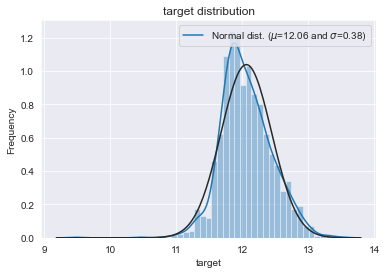

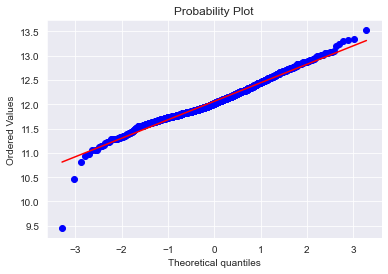

In [144]:
train_df['target'] = np.log1p(train_df['target'])

sns.distplot(train_df['target'], fit=norm)

(mu, sigma) = norm.fit(train_df['target'])
print(mu, sigma)

# 분포를 그래프에 그려봅시다.
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('target distribution')

# QQ-plot을 그려봅시다.
fig = plt.figure()
res = stats.probplot(train_df['target'], plot=plt)
plt.show()

정규 분포에 매우 근접하게 값들이 바뀐 것을 알 수 있습니다.

# Feature Engineering

데이터를 하나로 묶어서 사용하겠습니다.

In [145]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.target.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['target'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2700, 13)


전체 데이터 에서 null값을 확인 해 보도록 하겠습니다.

In [146]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio


결측치가 존재하지 않습니다.

수치형 값들 중 범주형인 특성들을 변환합니다.

In [147]:
categorical_feature = train_df.columns[train_df.dtypes == 'object']
print("카테고리형 데이터는 다음과 같습니다.", list(categorical_feature))

카테고리형 데이터는 다음과 같습니다. ['Exter Qual', 'Kitchen Qual', 'Bsmt Qual']


In [148]:
all_data['Exter Qual'] = all_data['Exter Qual'].apply(str)
all_data['Kitchen Qual'] = all_data['Kitchen Qual'].apply(str)
all_data['Bsmt Qual'] = all_data['Bsmt Qual'].apply(str)

범주형 데이터를 label encoding으로 변환합니다.

In [149]:
all_data.columns

Index(['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt'],
      dtype='object')

In [150]:
from sklearn.preprocessing import LabelEncoder

cols = ('Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2700, 13)


## Adding one more important feature

참고:https://dacon.io/competitions/official/235869/codeshare/4304?page=1&dtype=recent

- 2층 면적 2nd flr SF= 지상층 생활 면적 - 1층 면적

- 2층 여부 2nd flr= 1(지상층 생활 면적 - 1층 면적 > 0), 0(지상층 생활 면적 - 1층 면적 < 0)

- 전체 면적 Total SF = 지상층 생활 면적 + 지하실 면적 + 차고 면적

- 차고 밖/안 Garage In/Out = 1(지상층 생활 면적 != 1층 면적), 0(지상층 생활 면적 == 1층 면적)

- 리모델링 연도 차 Year Gap Remod = 리모델링 연도 - 완공 연도

- 차고 자리당 면적 Car Area= 차고 면적/차고 자리 개수

- 품질 합 Sum Qual = (전반적 + 부억 + 재료 + 지하실) 품질

In [151]:
def feature_eng(data_):
  data = all_data.copy()
  data['Year Gap Remod'] = data['Year Remod/Add'] - data['Year Built']
  data['Car Area'] = data['Garage Area']/data['Garage Cars']
  data['2nd flr SF'] = data['Gr Liv Area'] - data['1st Flr SF']
  data['2nd flr'] = data['2nd flr SF'].apply(lambda x : 1 if x > 0 else 0)
  data['Total SF'] = data[['Gr Liv Area',"Garage Area", "Total Bsmt SF"]].sum(axis=1)
  data['Sum Qual'] = data[["Exter Qual", "Kitchen Qual", "Overall Qual"]].sum(axis=1)
  data['Garage InOut'] = data.apply(lambda x : 1 if x['Gr Liv Area'] != x['1st Flr SF'] else 0, axis=1)
  return data

all_data = feature_eng(all_data)

In [152]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Overall Qual    2700 non-null   int64  
 1   Gr Liv Area     2700 non-null   int64  
 2   Exter Qual      2700 non-null   int32  
 3   Garage Cars     2700 non-null   int64  
 4   Garage Area     2700 non-null   int64  
 5   Kitchen Qual    2700 non-null   int32  
 6   Total Bsmt SF   2700 non-null   int64  
 7   1st Flr SF      2700 non-null   int64  
 8   Bsmt Qual       2700 non-null   int32  
 9   Full Bath       2700 non-null   int64  
 10  Year Built      2700 non-null   int64  
 11  Year Remod/Add  2700 non-null   int64  
 12  Garage Yr Blt   2700 non-null   int64  
 13  Year Gap Remod  2700 non-null   int64  
 14  Car Area        2699 non-null   float64
 15  2nd flr SF      2700 non-null   int64  
 16  2nd flr         2700 non-null   int64  
 17  Total SF        2700 non-null   i

## Skewed feature

In [153]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

In [154]:
# 수치형 데이터에서 skewness 체크
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Year Gap Remod,2.089789
2nd flr SF,0.555686
Total Bsmt SF,0.473151
Garage Area,0.449938
Total SF,0.430268
1st Flr SF,0.382317
Overall Qual,0.294508
Garage Cars,0.287996
Gr Liv Area,0.285609
2nd flr,0.205521


## Box Cox Transformation of (highly) skewed features

Box-Cox Transformation은 정규 분포가 아닌 데이터를 정규 분포 형태로 변환하는 방법 중 하나입니다.

In [155]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 20 skewed numerical features to Box Cox transform


## Getting dummy categorical features

범주형 데이터를 get_dummies를 이용하여 변환합니다. 그리고 다시 train_df와 test_df로 나누겠습니다.

In [156]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

(2700, 20)


In [157]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Overall Qual    2700 non-null   float64
 1   Gr Liv Area     2700 non-null   float64
 2   Exter Qual      2700 non-null   float64
 3   Garage Cars     2700 non-null   float64
 4   Garage Area     2700 non-null   float64
 5   Kitchen Qual    2700 non-null   float64
 6   Total Bsmt SF   2700 non-null   float64
 7   1st Flr SF      2700 non-null   float64
 8   Bsmt Qual       2700 non-null   float64
 9   Full Bath       2700 non-null   float64
 10  Year Built      2700 non-null   float64
 11  Year Remod/Add  2700 non-null   float64
 12  Garage Yr Blt   2700 non-null   float64
 13  Year Gap Remod  218 non-null    float64
 14  Car Area        2699 non-null   float64
 15  2nd flr SF      1214 non-null   float64
 16  2nd flr         2700 non-null   float64
 17  Total SF        2700 non-null   f

## Inputing missing values


In [158]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio
Year Gap Remod,91.925926
2nd flr SF,55.037037
Car Area,0.037037


리모델링 연도 차, 2층 면적, 차고 자리당 면적에서 결측치가 발생 되었습니다.

In [159]:
all_data.drop(['Year Gap Remod'], axis=1, inplace=True)
all_data.drop(['2nd flr SF'], axis=1, inplace=True)
all_data.drop(['Car Area'], axis=1, inplace=True)

3개 컬럼을 확인 해본결과 리모델링 연도 차, 2층 면적은 결측치 개수가 매우 많아서 삭제하기로 하였습니다.

또한 Car Area 컬럼에는 inf라는 값이 상당히 많이 있어서 이것또한 삭제 하였습니다.

In [160]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio


In [161]:
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Modeling

In [162]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

In [163]:
# Validation function
n_folds = 5

def nmale_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    nmae = np.mean(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_absolute_error", cv = kf))
    return (nmae)

## LASSO Regression

- 이 모델은 이상치에 매우 민감합니다. 그렇기에 이런 이상치를 좀 더 규제하기 위해 pipeline에 RobustScaler() 메서드를 이용합니다.

## Elastic Net Regression

이 모델 또한 이상치를 위해 똑같이 합니다.

In [164]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

## Kernel Ridge Regression

In [165]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

## Gradient Boosting Regression

huber 손실 함수로 이상치를 관리합니다. 이 손실함수는 다른 손실함수에 비해 이상치에 대해 민감하지 않습니다.

In [166]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

## XGBoost

각 매개변수, 즉 하이퍼 파라미터 설정은 bayesian optimization을 사용했다고 하였습니다.

In [167]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

## LightGBM

In [168]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

이제 이 모델들을 이용해 교차 검증을 통해 score을 구해봅시다.

In [169]:
score = nmale_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1074 (0.0000)



In [170]:
score = nmale_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1074 (0.0000)



In [171]:
score = nmale_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1013 (0.0000)



In [172]:
score = nmale_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1005 (0.0000)



In [173]:
score = nmale_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[18:00:37] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:00:38] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:00:39] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings 

In [174]:
score = nmale_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

# Stacking models

## Simplest Stacking approach : Averaging base models

- 우선 모델들의 성능을 평균하여 사용하는 것으로 시작해봅시다. class를 만들어 캡슐화하고, 코드를 재사용할 수 있게 만들어봅시다.

In [175]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [176]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = nmale_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.0981 (0.0000)



## Averaged base models score

- 이제 ENet, GBoost, KRR and lasso를 이용해 score를 내봅시다. 다른 모델을 추가해도 됩니다.

In [177]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = nmale_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.0981 (0.0000)



## Less simple Stacking : Adding a Meta-model

- 이 방법은 meta model을 추가하고, base model들의 평균과 이 out-of-folds 예측을 이용하여 meta-model을 훈련시킵니다.

In [178]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

## Stacking Averaged models Score

In [179]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, KRR),
    meta_model=(lasso)
)

score = nmale_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0960 (0.0000)


## Emsembling StackedRegressor, XGBoost and LightGBM

- 위에서 만든 XGBoost와 LightBGM을 이용하여 최종 결과를 만들겠습니다.

우선 rmsle 함수를 먼저 정의합니다.

In [180]:
# 평가 기준 정의
def NMAE(y, y_pred):
    mae = np.mean(np.abs(y-y_pred))
    score = mae / np.mean(np.abs(y))
    return score

# Final Training and Prediction

## StackedRegressor

In [181]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(NMAE(y_train, stacked_train_pred))

0.005812733979631749


## XGBoost

In [182]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(NMAE(y_train, xgb_train_pred))

[18:05:21] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.006017546318884577


## LightGBM

In [183]:
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(NMAE(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.006229547286511142


In [184]:
'''NMAE on the entire Train data when averaging'''

print('NMAE score on train data:')
print(NMAE(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

NMAE score on train data:
0.005792892612208922


In [185]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [186]:
sample_submission = pd.read_csv('sample_submission.csv')

In [187]:
sample_submission['target'] = ensemble
sample_submission.to_csv('houseprice_final.csv',index=False)

In [189]:
ensemble1 = stacked_pred*0.50 + xgb_pred*0.25 + lgb_pred*0.25

In [190]:
sample_submission['target'] = ensemble1
sample_submission.to_csv('houseprice_final2.csv',index=False)

In [191]:
ensemble2 = stacked_pred*0.40 + xgb_pred*0.3 + lgb_pred*0.3

In [192]:
sample_submission['target'] = ensemble2
sample_submission.to_csv('houseprice_final3.csv',index=False)